Having trained the U-Net and ME-Unet, let's compute some statistical tests to compare their performance on test and held-out site data

In [1]:
DATADIR = '/endosome/archive/bioinformatics/DLLab/KevinNguyen/data/multisite_prostate/slices'
UNET_WEIGHTS = '/archive/bioinformatics/DLLab/KevinNguyen/results/MEDL/prostate_segmentation_20210110/test/final_weights.h5'
MEUNET_WEIGHTS = '/archive/bioinformatics/DLLab/KevinNguyen/results/MEDL/prostate_segmentation_me_20210110/random_slope_featurewise_transfer/val/final_weights.h5' 
SEED = 493
IMAGESHAPE = (384, 384, 1)
GROUPS = 5

In [33]:
import os
import sys
import argparse
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append('../')
from medl.models.unet import unet # pylint: disable=import-error
from medl.models.losses import dice_bce_loss, dice # pylint: disable=import-error
from medl.models.callbacks import SaveImagesCallback # pylint: disable=import-error
from prostate_datagenerator import SegmentationDataGenerator # pylint: disable=import-error
from candidate_architectures.random_slope_featurewise_hpo import unet as me_unet # pylint: disable=import-error

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [29]:
def dice_coef(yTrue, yPred):
    yPredMask = (yPred >= 0.5).astype(np.float)
    intersection = np.sum(yTrue * yPredMask, axis=(1, 2, 3))
    total = np.sum(yTrue, axis=(1, 2, 3)) + np.sum(yPredMask, axis=(1, 2, 3))
    return 2 * intersection / total

In [46]:
# Create data generators
test_data = SegmentationDataGenerator(os.path.join(DATADIR, 'test', 'image'),
                                        os.path.join(DATADIR, 'test', 'mask'),
                                        IMAGESHAPE,
                                        return_group=True,
                                        batch_size=10,
                                        samplewise_center=True,
                                        samplewise_std_normalization=True,
                                        seed=SEED)
hk_data = SegmentationDataGenerator(os.path.join(DATADIR, 'hk', 'image'),
                                        os.path.join(DATADIR, 'hk', 'mask'),
                                        IMAGESHAPE,
                                        return_group=True,
                                        batch_size=10,
                                        samplewise_center=True,
                                        samplewise_std_normalization=True,
                                        seed=SEED)    

arrInputTest = np.concatenate([t[0][0] for t in test_data], axis=0)                
arrGroupTest = np.concatenate([t[0][1] for t in test_data], axis=0)
arrSegTest = np.concatenate([t[1] for t in test_data], axis=0)
arrInputHK = np.concatenate([t[0][0] for t in hk_data], axis=0)                
arrGroupHK = np.zeros((arrInputHK.shape[0], GROUPS))
arrSegHK = np.concatenate([t[1] for t in hk_data], axis=0)

In [32]:
model = unet(input_size=IMAGESHAPE, pretrained_weights=UNET_WEIGHTS)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4), 
            loss=dice_bce_loss, 
            metrics=[dice])
arrPredTest = model.predict(arrInputTest)
arrPredHK = model.predict(arrInputHK)

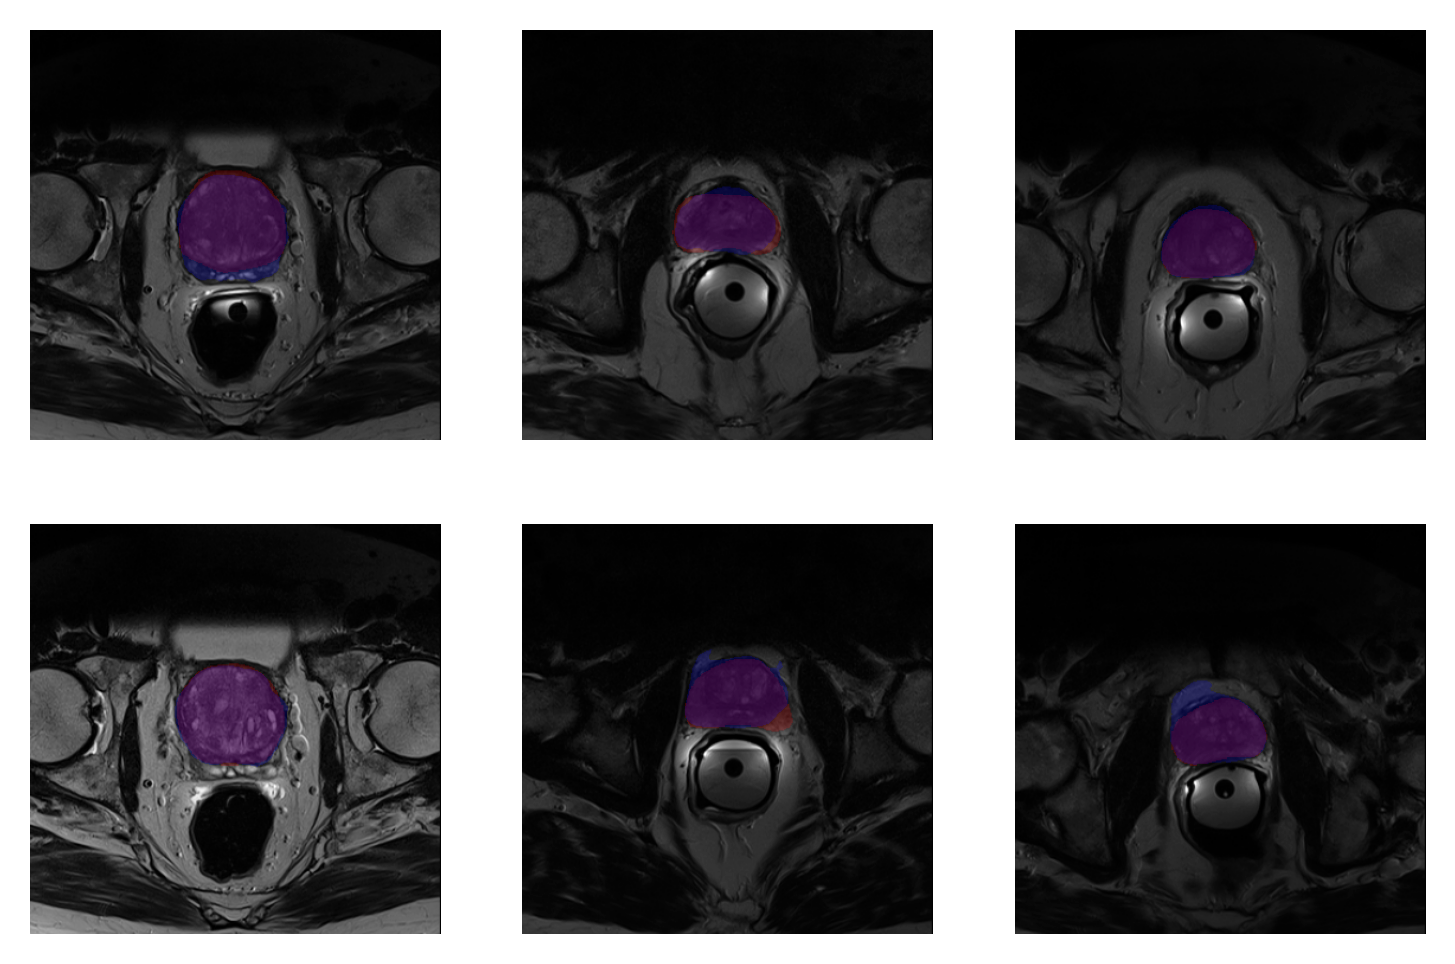

In [56]:
arrDiceTest = dice_coef(arrSegTest, arrPredTest)
arrDiceHK = dice_coef(arrSegHK, arrPredHK)

fig, ax = plt.subplots(2, 3, figsize=(6, 4), dpi=300)
for i in range(6):
    k = 37 + i
    arrImg = arrInputHK[k,].squeeze()
    ax.flatten()[i].imshow(np.rot90(arrImg, k=-1), cmap='Greys_r')
    arrTrue = np.zeros(arrImg.shape + (4,))
    arrTrue[..., 0] = arrSegHK[k,].squeeze()
    arrTrue[..., -1] = arrSegHK[k,].squeeze()
    ax.flatten()[i].imshow(np.rot90(arrTrue, k=-1), alpha=0.2)
    arrPred = np.zeros(arrImg.shape + (4,))
    arrPred[..., 2] = arrPredHK[k,].squeeze() >= 0.5
    arrPred[..., -1] = arrPredHK[k,].squeeze() >= 0.5
    ax.flatten()[i].imshow(np.rot90(arrPred, k=-1), alpha=0.2)
    ax.flatten()[i].axis('off')
fig.show()
fig.savefig('prostate_segmentation_hk.png')

In [47]:
# del model
modelME = me_unet(IMAGESHAPE, GROUPS, 
            {'re_int_loc_range': 1, 
            're_int_std_min': 0.1, 
            're_int_std_range': 0.1, 
            'prior_std': 0.1,
            'learning_rate': 1e-3,
            'seg_loss_weight': 1000})
modelME.load_weights(MEUNET_WEIGHTS)
modelME.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4), 
            loss=dice_bce_loss, 
            metrics=[dice])
arrPredTestME = modelME.predict((arrInputTest, arrGroupTest))
arrPredHKME = modelME.predict((arrInputHK, arrGroupHK))

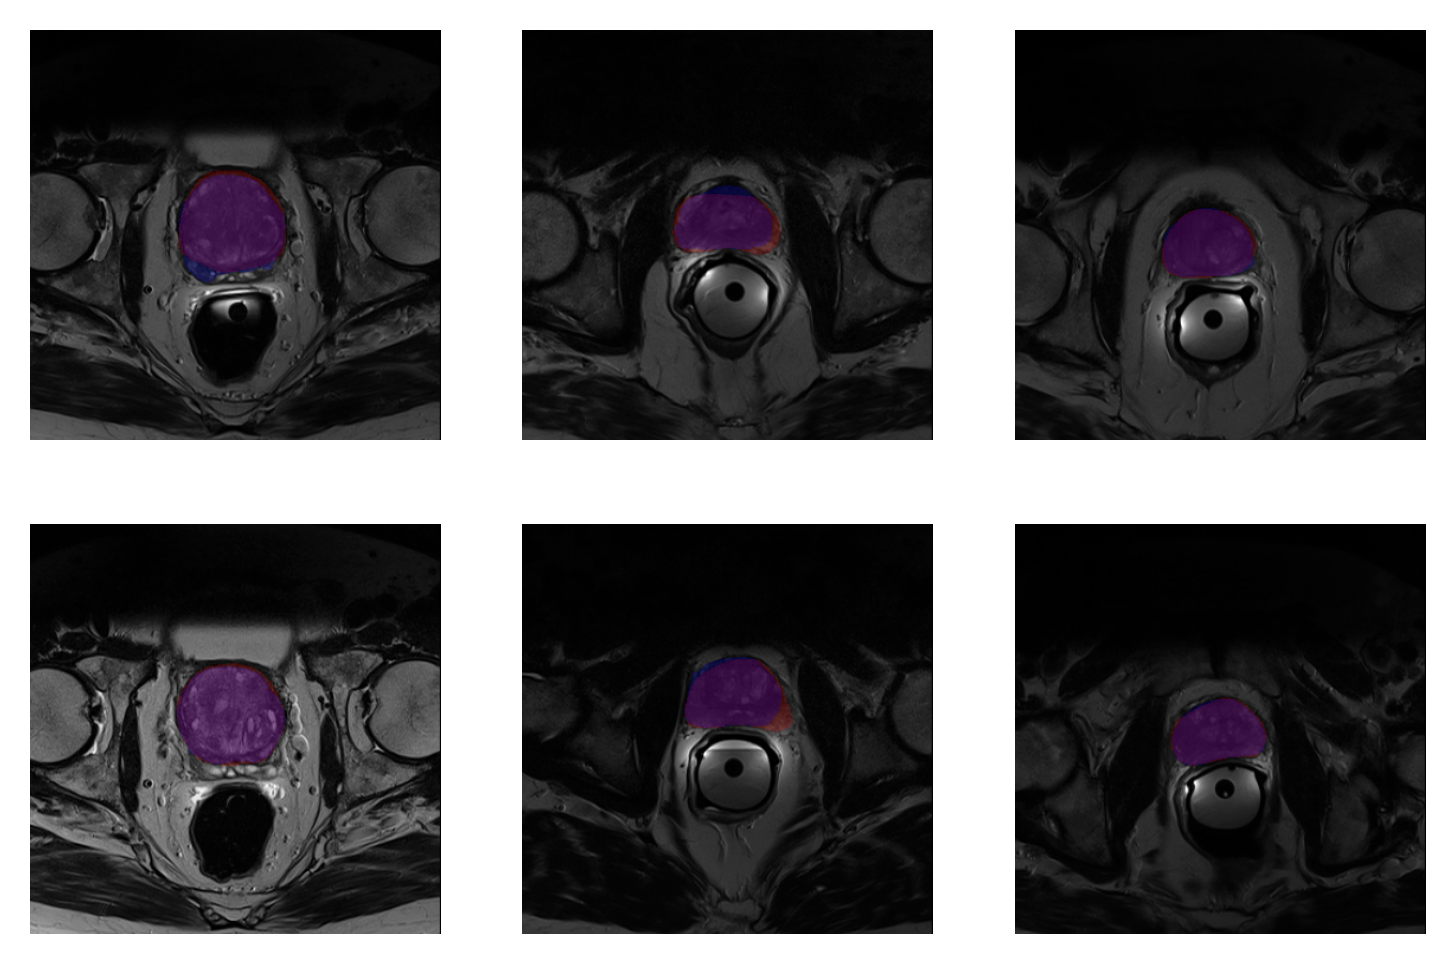

In [57]:
arrDiceTestME = dice_coef(arrSegTest, arrPredTestME)
arrDiceHKME = dice_coef(arrSegHK, arrPredHKME)

fig, ax = plt.subplots(2, 3, figsize=(6, 4), dpi=300)
for i in range(6):
    k = 37 + i
    arrImg = arrInputHK[k,].squeeze()
    ax.flatten()[i].imshow(np.rot90(arrImg, k=-1), cmap='Greys_r')
    arrTrue = np.zeros(arrImg.shape + (4,))
    arrTrue[..., 0] = arrSegHK[k,].squeeze()
    arrTrue[..., -1] = arrSegHK[k,].squeeze()
    ax.flatten()[i].imshow(np.rot90(arrTrue, k=-1), alpha=0.2)
    arrPred = np.zeros(arrImg.shape + (4,))
    arrPred[..., 2] = arrPredHKME[k,].squeeze() >= 0.5
    arrPred[..., -1] = arrPredHKME[k,].squeeze() >= 0.5
    ax.flatten()[i].imshow(np.rot90(arrPred, k=-1), alpha=0.2)
    ax.flatten()[i].axis('off')
fig.show()
fig.savefig('prostate_segmentation_hk_mixedeffects.png')

In [55]:
print('Base U-NET')
print(f'Mean test Dice: {arrDiceTest.mean():.03f}, mean HK Dice: {arrDiceHK.mean():.03f}')
print('ME U-NET')
print(f'Mean test Dice: {arrDiceTestME.mean():.03f}, mean HK Dice: {arrDiceHKME.mean():.03f}')
t, p = scipy.stats.ttest_rel(arrDiceTestME, arrDiceTest)
print(f'Paired t-test for test data: t = {t:.05f}, p = {p:.05f}')
t, p = scipy.stats.ttest_rel(arrDiceHKME, arrDiceHK)
print(f'Paired t-test for HK data: t = {t:.05f}, p = {p:.05f}')

Base U-NET
Mean test Dice: 0.860, mean HK Dice: 0.764
ME U-NET
Mean test Dice: 0.875, mean HK Dice: 0.810
Paired t-test for test data: t = 2.74796, p = 0.00631
Paired t-test for HK data: t = 4.55457, p = 0.00001
